## 6. Nonlinear ensemble filtering for the Lorenz-63 problem

In this notebook, we apply the stochastic map filter developed in Spantini et al. [5] to the Lorenz-63 problem.

References: 

[1] Evensen, G., 1994. Sequential data assimilation with a nonlinear quasi‐geostrophic model using Monte Carlo methods to forecast error statistics. Journal of Geophysical Research: Oceans, 99(C5), pp.10143-10162.

[2] Asch, M., Bocquet, M. and Nodet, M., 2016. Data assimilation: methods, algorithms, and applications. Society for Industrial and Applied Mathematics.

[3] Bishop, C.H., Etherton, B.J. and Majumdar, S.J., 2001. Adaptive sampling with the ensemble transform Kalman filter. Part I: Theoretical aspects. Monthly weather review, 129(3), pp.420-436. 

[4] Lorenz, E.N., 1963. Deterministic nonperiodic flow. Journal of atmospheric sciences, 20(2), pp.130-141.

[5] Spantini, A., Baptista, R. and Marzouk, Y., 2019. Coupling techniques for nonlinear ensemble filtering. arXiv preprint arXiv:1907.00389.

### The basic steps
To carry out sequential inference in `TransportBasedInference`, we need to carry out a few basic steps:
* **Specify the problem**: Define the state-space model: initial condition, dynamical and observation models (including process and observation noise)
* **Specify the inflation parameters**: Determine the levels of covariance inflation to properly balance the dynamical system and the observations from the truth system
* **Specify the filter**: Choose the ensemble filter to assimilate the observations in the state estimate
* **Perform the sequential inference**

We will go through all of these here.

In [1]:
using Revise
using LinearAlgebra
using TransportBasedInference
using Statistics
using Distributions
using OrdinaryDiffEq

Load some packages to make nice figures

In [25]:
using Plots
default(fontfamily = "Computer Modern",
        tickfont = font("Computer Modern", 9), 
        titlefont = font("Computer Modern", 14), 
        guidefont = font("Computer Modern", 12),
        legendfont = font("Computer Modern", 10),
        grid = false)

using LaTeXStrings
using ColorSchemes

The Lorenz-63  model is a three dimensional system that models the atmospheric convection [4]. This system is a classical benchmark problem in data assimilation. The state $\boldsymbol{x} = (x_1, x_2, x_3)$ is governed by the following set of ordinary differential equations:

\begin{equation}
\begin{aligned}
&\frac{\mathrm{d} x_1}{\mathrm{d} t}=\sigma(x_2-x_1)\\
&\frac{\mathrm{d} x_2}{\mathrm{d} t}=x_1(\rho-x_2)-x_2\\
&\frac{\mathrm{d} x_3}{\mathrm{d} t}=x_1 x_2-\beta x_3,
\end{aligned}
\end{equation}

where $\sigma = 10, \beta = 8/3, \rho = 28$. For these values, the system is chaotic and behaves like a strange attractor. We integrate this system of ODEs with time step $\Delta t_{dyn} = 0.05$. The state is fully observed $h(t,\boldsymbol{x}) = \boldsymbol{x}$ with $\Delta t_{obs}=0.1$. The initial distribution $\pi_{\mathsf{X}_0}$ is the standard Gaussian. The process noise is Gaussian with zero mean and covariance $10^{-4}\boldsymbol{I}_3$. The measurement noise has a Gaussian distribution with zero mean and covariance $\theta^2\boldsymbol{I}_3$ where $\theta^2 = 4.0$.

### Simple twin-experiment

Define the dimension of the state and observation vectors

In [26]:
Nx = 3
Ny = 3

3

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [27]:
Δtdyn = 0.05
Δtobs = 0.2

0.2

Define the time span of interest

In [28]:
t0 = 0.0
tf = 1000.0
Tf = ceil(Int64, (tf-t0)/Δtobs)

5000

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [29]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 3
μ: [0.0, 0.0, 0.0]
Σ: [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]
)


We construct the state-space representation `F` of the system composed of the deterministic part of the dynamical and observation models. 

The dynamical model is provided by the right hand side of the ODE to solve. For a system of ODEs, we will prefer an in-place syntax `f(du, u, p, t)`, where `p` are parameters of the model.
We rely on `OrdinaryDiffEq` to integrate the dynamical system with the Tsitouras 5/4 Runge-Kutta method adaptive time marching. 

We assume that the state is fully observable, i.e. $h(x, t) = x$.

In [30]:
h(x, t) = x
F = StateSpace(lorenz63!, h)

StateSpace(TransportBasedInference.lorenz63!, h)

Define the additive inflation for the dynamical and observation models

In [31]:
### Process and observation noise
σx = 1e-6
σy = 2.0

ϵx = AdditiveInflation(Nx, zeros(Nx), σx)
ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0])

In [32]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx, ϵy, π0, 0, 0, 0, F);

To perform the nonlinear ensemble filtering, we first need to estimate the transport map $\boldsymbol{S}^{\boldsymbol{\mathcal{X}}}$.

In this notebook, we are going to assume that the basis of features does not change over time, but solely the coefficients $c_{\boldsymbol{\alpha}}$ of the expansion. 


To estimate the map, we generate joint samples $(\boldsymbol{y}^i, \boldsymbol{x}^i), \; i = 1, \ldots, N_e$ where $\{\boldsymbol{x}^i\}$ are i.i.d. samples from pushforward of the standard Gaussian distribution by the flow of the Lorenz-63 system.

In [33]:
# Time span
tspan = (0.0, tf)

(0.0, 1000.0)

Set initial condition of the true system

In [34]:
x0 = rand(model.π0);

In [35]:
data = generate_lorenz63(model, x0, Tf);

Initialize the ensemble matrix `X` $\in \mathbb{R}^{(N_y + N_x) \times N_e}$.

In [36]:
# Ensemble size
Ne = 160

X0 = zeros(model.Ny + model.Nx, Ne)

# Generate the initial conditions for the state.
viewstate(X0, model.Ny, model.Nx) .= rand(model.π0, Ne)

3×160 view(::Matrix{Float64}, 4:6, :) with eltype Float64:
 -0.0910215  -0.454976  -0.316371  …   0.354828   0.30741    0.307448
  1.00236     0.257764   0.844356      0.914607  -1.3591    -0.263127
 -1.2608     -0.971855  -0.298979     -0.105374  -0.269069   1.37621

Use the stochastic ensemble Kalman filter for the spin-up phase. There is no reason to use the stochastic map filter over the first cycles, as the performance of the inference is determined by the quality of the ensemble, not the quality of the filter.

In [37]:
enkf = StochEnKF(x->x, ϵy, Δtdyn, Δtobs)

Stochastic EnKF  with filtered = false


In [38]:
Xenkf = seqassim(F, data, Tf, model.ϵx, enkf, deepcopy(X0), model.Ny, model.Nx, t0);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


In [39]:
tspin = 500.0
Tspin = ceil(Int64, (tspin-t0)/Δtobs)

2500

Time average root-mean-squared error 

In [40]:
rmse_enkf = mean(map(i->norm(data.xt[:,i]-mean(Xenkf[i+1]; dims = 2))/sqrt(Nx), Tspin:Tf))

0.7728932897326932

Initialize the ensemble matrix for the radial stochastic map filter

In [41]:
Xspin = vcat(zeros(Ny, Ne), deepcopy(Xenkf[Tspin+1]))

6×160 Matrix{Float64}:
   0.0       0.0       0.0       0.0     …    0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
   0.0       0.0       0.0       0.0          0.0       0.0       0.0
 -16.4828  -16.1137  -16.1672  -17.4243     -17.3143  -17.3981  -15.662
 -17.9675  -16.4061  -17.4215  -19.0337     -18.6212  -18.5747  -16.4003
  36.5112   37.158    36.2786   38.0395  …   38.3603   38.5668   35.7521

In [42]:
tsmf = 1000.0
Tsmf = ceil(Int64, (tsmf-tspin)/Δtobs)

2500

Initialize the structure of the map

In [43]:
p = 2
order = [[-1], [p; p], [-1; p; 0], [-1; p; p; 0]]
# order = [[-1], [-1; -1], [-1; -1; -1], [p; -1; -1 ;p], [-1; p; -1; p; p], [-1; -1; p; p; p; p]]

# parameters of the radial map
γ = 2.0
λ = 0.0
δ = 1e-8
κ = 10.0
β = 1.0

dist = Float64.(metric_lorenz(3))
idx = vcat(collect(1:Ny)',collect(1:Ny)')

smf = SparseRadialSMF(x->x, F.h, β, ϵy, order, γ, λ, δ, κ, 
                      Ny, Nx, Ne, 
                      Δtdyn, Δtobs, 
                      dist, idx; islocalized = true)

SparseRadialSMF(var"#15#16"(), h, MultiplicativeInflation(1.0), AdditiveInflation(3, [0.0, 0.0, 0.0], [4.0 0.0 0.0; 0.0 4.0 0.0; 0.0 0.0 4.0], [2.0 0.0 0.0; 0.0 2.0 0.0; 0.0 0.0 2.0]), Sparse Radial Map of dimension Nx = 4 and order p = [[-1], [2, 2], [-1, 2, 0], [-1, 2, 2, 0]]
        with parameters (γ, λ, δ, κ) = (2.0, 0.0, 1.0e-8, 10.0)
, 3, 3, 0.05, 0.2, [0.0 1.0 1.0; 1.0 0.0 1.0; 1.0 1.0 0.0], [1 2 3; 1 2 3], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], false, true)

In [44]:
Xsmf = seqassim(F, data, Tsmf, model.ϵx, smf, deepcopy(Xspin), model.Ny, model.Nx, tspin);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


In [45]:
rmse_smf = mean(map(i->norm(data.xt[:,Tspin+i]-mean(Xsmf[i+1]; dims = 2))/sqrt(Nx), 1:Tsmf))

0.5898271141251634

In [46]:
(rmse_enkf-rmse_smf)/rmse_enkf

0.23685828048894514

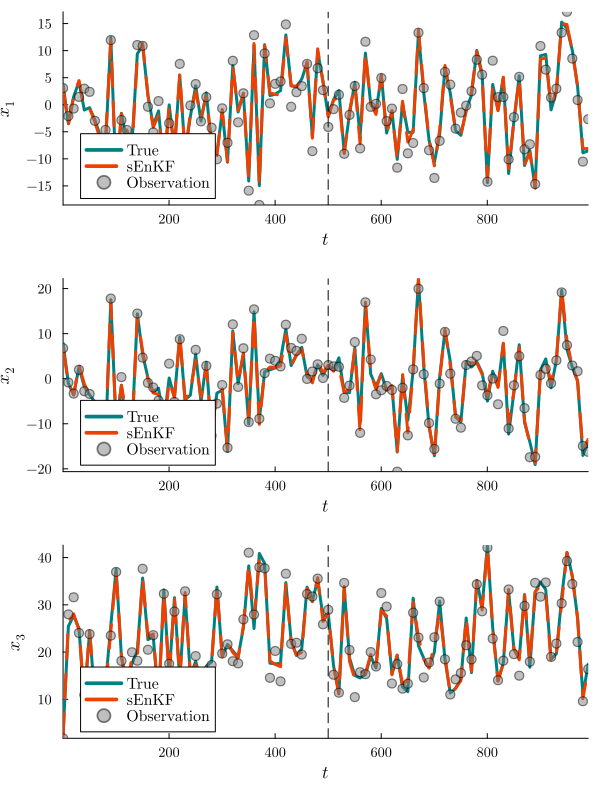

In [47]:
# Plot the trajectories
nb = 1
ne = Tspin+Tsmf
Δ = 50
plt = plot(layout = grid(3,1), xlim = (-Inf, Inf), ylim = (-Inf, Inf), xlabel = L"t", 
           size = (600, 800))

for i =1:3
    plot!(plt[i,1], data.tt[nb:Δ:ne], data.xt[i,nb:Δ:ne], linewidth =  3, color = :teal, 
          ylabel = latexstring("x_"*string(i)), legend = :bottomleft, label = "True")
    plot!(plt[i,1], data.tt[nb:Δ:ne], mean_hist(vcat(Xenkf[1:Tspin+1], Xsmf[2:end]))[i,1+nb:Δ:1+ne], linewidth = 3, grid = false,
          color = :orangered2, linestyle = :dash, label = "sEnKF")
    scatter!(plt[i,1], data.tt[nb:Δ:ne], data.yt[i,nb:Δ:ne], linewidth = 3, color = :grey, 
          markersize = 5, alpha = 0.5, label  = "Observation")
    vline!(plt[i,1], [tspin], color = :grey2, linestyle = :dash, label = "")
end

plt